In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

print('numpy ver.: ' + np.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)
print('imageio ver.: ' + imageio.__version__)

numpy ver.: 1.23.5
tensorflow ver.: 2.10.0
keras ver.: 2.10.0
imageio ver.: 2.25.1


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Descargar y cargar el archivo
# fpath = keras.utils.get_file(
#     "moving_mnist.npy",
#     "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
# )
# dataset = np.load(fpath)
dataset = np.load('../dataset/mnist_test_seq.npy')
dataset.shape

(20, 10000, 64, 64)

In [4]:
# Intercambiamos los ejes que representan el número de fotogramas y el número de muestras de datos
dataset = np.swapaxes(dataset, 0, 1)

# Seleccionaremos 1000 de los 10000 ejemplos en total y los usaremos.
dataset = dataset[:1000, ...]

# Agregue una dimensión de canal ya que las imágenes están en escala de grises
dataset = np.expand_dims(dataset, axis=-1)
dataset.shape

(1000, 20, 64, 64, 1)

In [5]:
# selecionamos indices al azar para dividir el dataset: 90%->train, 10%->val
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]

# Dividir en conjuntos de entrenamiento y validación usando la indexación para optimizar la memoria.
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Notmalizamos los datos en el rango 0-1
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

print(f'Training dataset shape: {train_dataset.shape}')
print(f'Validation dataset shape: {val_dataset.shape}')

Training dataset shape: (900, 20, 64, 64, 1)
Validation dataset shape: (100, 20, 64, 64, 1)


In [6]:
# Definiremos una función auxiliar para desplazar los fotogramas, donde
# `x` son los fotogramas de 0 a n - 1, e `y` son los fotogramas de 1 a n.
def desplazar_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [7]:
# Aplicar la función de procesamiento a los conjuntos de datos.
x_train, y_train = desplazar_frames(train_dataset)
x_val, y_val = desplazar_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Mostrando los frames del ejemplo 423


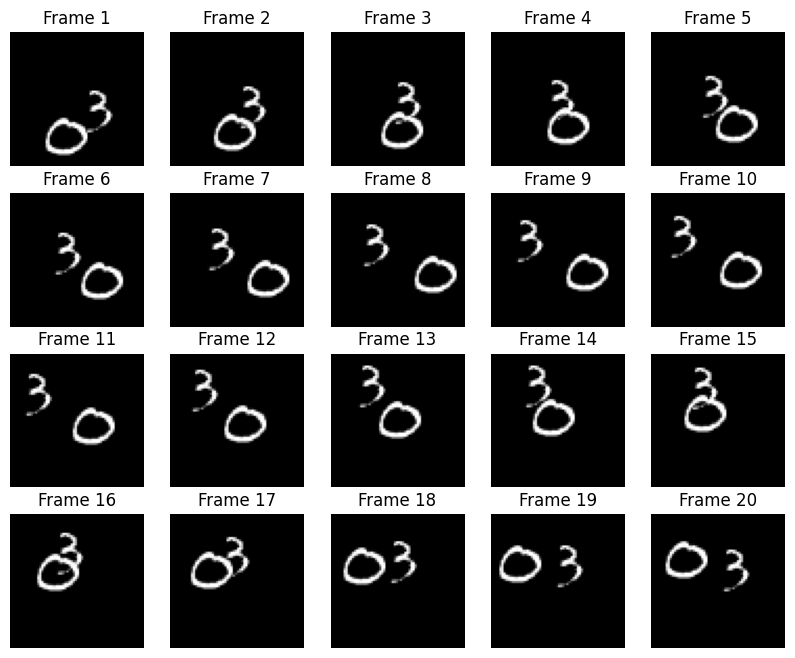

In [8]:
# Construir una figura donde se pueda visualizar los frames
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plotear cada uno de los frames secuenciales para un dato aleatorio
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f'Frame {idx + 1}')
    ax.axis('off')

print(f"Mostrando los frames del ejemplo {data_choice}")
plt.show()

Construcion del modelo

In [14]:
# Construir la capa input sin un tamaño de frames definido
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# Construiremos 3 capas `ConvLSTM2D` con batch normalization (normalizacion por lotes)
# seguido por una capa `Conv3D` para el output espaciotemporal
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (5, 5),
    padding = 'same',
    return_sequences = True,
    activation = 'relu'
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64, 
    kernel_size = (3, 3),
    padding = 'same',
    return_sequences = True,
    activation = 'relu'
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64, 
    kernel_size = (1, 1),
    padding = 'same',
    return_sequences = True,
    activation = 'relu'
)(x)
x = layers.Conv3D(
    filters = 1,
    kernel_size = (3, 3, 3),
    padding = 'same',
    activation = 'sigmoid'
)(x)

# Construimos el modelo y compilamos
model = keras.models.Model(inp, x)
model.compile(
    loss = keras.losses.binary_crossentropy, 
    optimizer = keras.optimizers.Adam()
)


Entremamiento

In [ ]:
# Defina algunas devoluciones de llamadas para mejorar el entrenamiento
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# definir los hiperparametros
epochs = 1
batch_size = 5

# entrenar el modelo con el training data
model.fit(
    x_train, 
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = [early_stopping, reduce_lr]
)

In [16]:
model.save('models/ConvLSTM_prediction_nextframe.h5')

In [10]:
model = tf.keras.models.load_model('models/ConvLSTM_prediction_nextframe_colab.h5', compile=False)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                             

Frame prediction visualization

1/1 [==============================] - 1s 1s/step


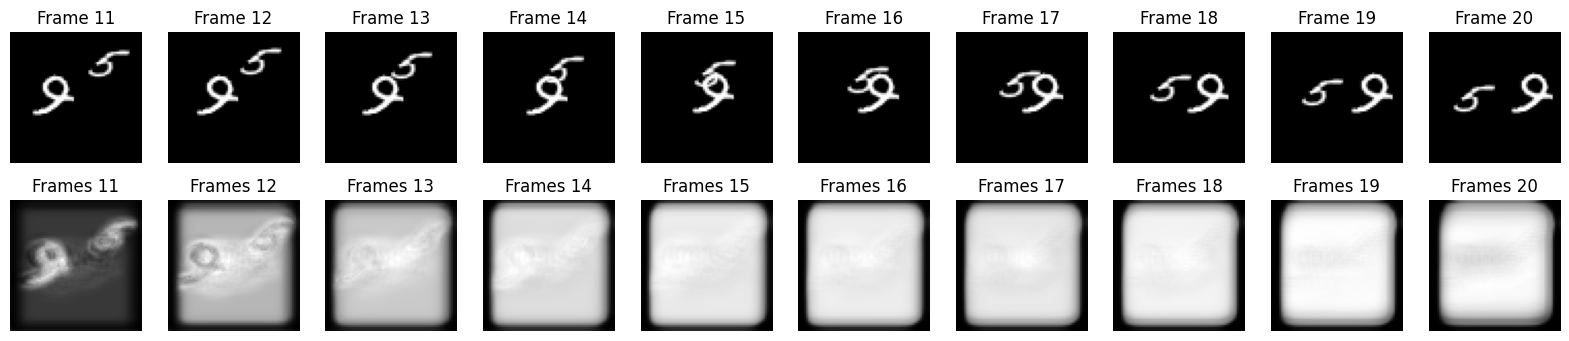

In [11]:
# Seleccionar un ejemplo aleatorio del dataset de validacion
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Elegir los primeros y ultimos 10 frames del ejemplo
frames = example[:10, ...]
original_frames = example[10:, ...]

# predecir un nuevo set de 10 frames
for _ in range(10):
    # Extraemos las prediciones del modelo y las procesamos
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Ampliamos el conjunto de frames predichos
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construir una figura para los originales y nuevos frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plotear los frames originales
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap='gray')
    ax.set_title(f'Frame {idx + 11}')
    ax.axis('off')

# Plotear los frames predichos
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap='gray')
    ax.set_title(f'Frames {idx + 11}')
    ax.axis('off')

plt.show()

Predecir videos

In [12]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 1s 1s/step
 Truth	Prediction
